In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum
# from pynrc.obs_nircam import model_to_hdulist, obs_hci
# from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, model_info, obs_wfe, obs_optimize

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import do_plot_contrasts, plot_images, plot_images_swlw

## Define Sources and their Reference PSF Stars

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [5]:
#                source,      dist, age, sptype, vmag kmag  W1   W2
args_sources = [('SAO 206462', 135,  10, 'F8V',  8.7, 5.8, 5.0, 4.0),
                ('TW Hya',      60,  10, 'M0V', 11.0, 7.3, 7.0, 6.9),
                ('MWC 758',    160,   5, 'A5V',  8.3, 5.7, 4.6, 3.5), # Lazareff et al. (2016)
                ('HL Tau',     140,   1, 'K5V',  15.1, 7.4, 5.2, 3.3),
                ('PDS 70',     113, 10, 'K7IV', 12.2, 8.8, 8.0, 7.7)]

# Corresponding reference stars
ref_sources =  [('HD 94771', 'G4V', 5.6),
                ('HD 94771', 'G4V', 5.6),
                ('HR 1889',  'F5III', 5.4),
                ('HR 1889',  'F5III', 5.4),
                ('HR 1889',  'F5III', 5.4)]

In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'YSOs/'

In [7]:
# List of filters
args_filter = [('F356W', 'MASK335R', 'CIRCLYOT'),
               ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 
    
subsize = 320

## SAO 206462

In [8]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[0.5,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[1.83711352e-01 2.70374786e+03 1.49556410e+00]


In [9]:
# Do the same for the reference source
name_ref, spt_ref, kmag_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

mag_ref, bp_ref = kmag_ref, bp_k
args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
ref = nrc_utils.source_spectrum(*args)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.95604015]


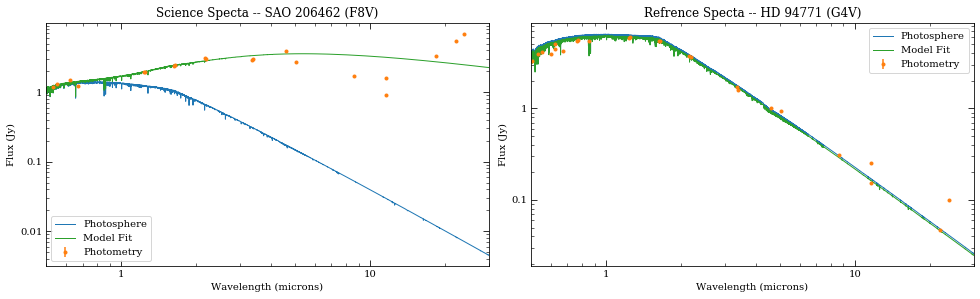

In [10]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

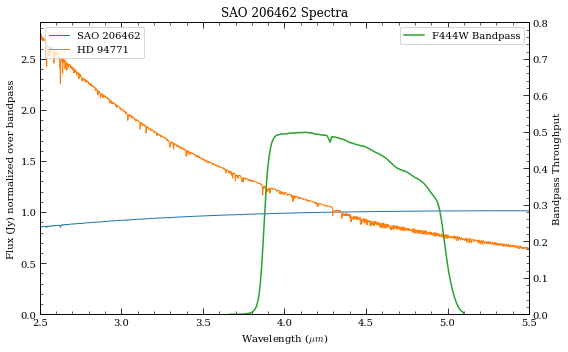

In [11]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    o = S.Observation(sp, bp, binset=bp.wave)
    sp.convert('Jy')
    f = sp.flux / o.effstim('Jy')

    ind = (w>=xr[0]) & (w<=xr[1])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized over bandpass')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [12]:
# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

In [13]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)


# # Generate initial observations for each filter(no WFE drift)
# def do_init(args_disk=None, fov_pix=None, verbose=True):
#     wfe_ref_drift = 0
#     obs_dict = obs_wfe(wfe_ref_drift, args_list, dist_sci, sp_ref=sp_ref, 
#                        args_disk=args_disk, fov_pix=fov_pix, verbose=verbose)
#     return obs_dict

# obs_dict = do_init(args_disk=args_disk, fov_pix=401, verbose=False)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [14]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,150,150)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

### Saturation 

In [15]:
# Max Saturation Values
dmax = []
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    dmax.append(dsat_asec)


F356W_MASK335R_CIRCLYOT
SAO 206462
  0 saturated pixel at NGROUP=2; Max Well: 0.21
  5 saturated pixel at NGROUP=10; Max Well: 1.13
  Sat Dist NG=2: 0.00 arcsec
HD 94771
  0 saturated pixel at NGROUP=2; Max Well: 0.09
  0 saturated pixel at NGROUP=10; Max Well: 0.51

F444W_MASK335R_CIRCLYOT
SAO 206462
  0 saturated pixel at NGROUP=2; Max Well: 0.13
  0 saturated pixel at NGROUP=10; Max Well: 0.71
  Sat Dist NG=2: 0.00 arcsec
HD 94771
  0 saturated pixel at NGROUP=2; Max Well: 0.04
  0 saturated pixel at NGROUP=10; Max Well: 0.19


### Photon Limit Curves

In [16]:
nsig = 5
roll = 10

In [17]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


### Reference Reconstruction Curves

In [18]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_recon10 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

wfe_list = [5]
curves_recon5 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

wfe_list = [2]
curves_recon2 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


### Basic PSF Subtraction Curves

In [19]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_ref

wfe_list = [5]

curves_basic = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=True)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


### Roll Subtraction

In [20]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon2 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [21]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_noref10 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

wfe_list = [5]
curves_noref5 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

wfe_list = [2]
curves_noref2 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


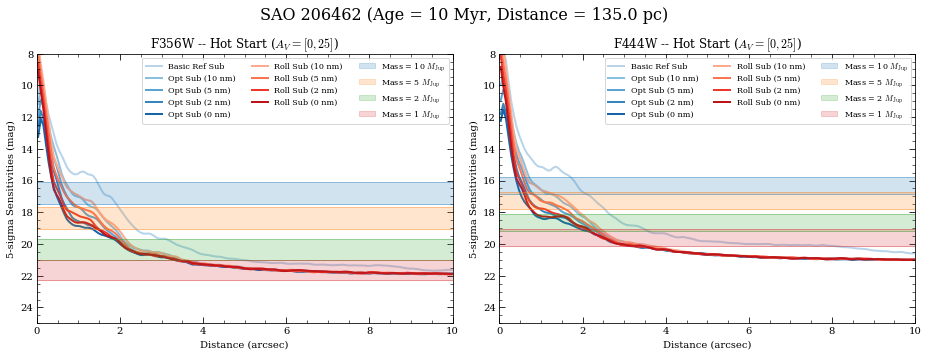

In [22]:
import matplotlib.patches as patches
from pynrc.obs_nircam import plot_planet_patches

fig, axes = plt.subplots(1,2, figsize=(13,5))
xlim1 = [0,5]
xlim2 = [0,10]
ylim  = [25,8]

curves_all = [curves_basic, curves_recon10, curves_recon5, curves_recon2, curves_photon]
labels = ['Basic Ref Sub', 'Opt Sub (10 nm)', 'Opt Sub (5 nm)', 
          'Opt Sub (2 nm)', 'Opt Sub (0 nm)']

lin_vals = np.linspace(0.2,0.7,len(curves_all))
cb = plt.cm.Blues_r(lin_vals)[::-1]

curves_all2 = [curves_noref10, curves_noref5, curves_noref2, curves_photon2]
labels2 = ['Roll Sub (10 nm)', 'Roll Sub (5 nm)', 
           'Roll Sub (2 nm)', 'Roll Sub (0 nm)']
lin_vals2 = np.linspace(0.2,0.7,len(curves_all2))
cr = plt.cm.Reds_r(lin_vals2)[::-1]

axes = axes.flatten()

for j, k in enumerate(filt_keys):
    for jj, cv in enumerate(curves_all):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cb[jj], zorder=1, lw=2, label=labels[jj])
    for jj, cv in enumerate(curves_all2):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cr[jj], zorder=1, lw=2, label=labels2[jj])
    
for j, ax in enumerate(axes):    
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))

    ax.set_xlim(xlim2)
    ax.set_ylim(ylim)
    
    obs = obs_dict[filt_keys[j]]
    plot_planet_patches(ax, obs, age=age_sci, update_title=True)
    
    ax.legend(ncol=3, loc=1, fontsize=8)
    
# Saturation levels
for j, ax in enumerate(axes):
    dy = ylim[1] - ylim[0]
    
    rect = patches.Rectangle((0, ylim[0]), dmax[j], dy, alpha=0.2,
                             color='k', zorder=2)
    ax.add_patch(rect)

fig.tight_layout()

dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''

fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
fig.subplots_adjust(top=0.85)
#fig.subplots_adjust(top=0.9)

fname = "{}_contrast2_{}.pdf".format(name_sci.replace(" ", ""), obs.mask)
fig.savefig(outdir+fname)

In [23]:
key_F444W = filt_keys[-1]
curves_roll_F444W = [curves_photon2[key_F444W][0], curves_noref2[key_F444W][0], 
                     curves_noref5[key_F444W][0], curves_noref10[key_F444W][0]]
wfe_list = [0,2,5,10]

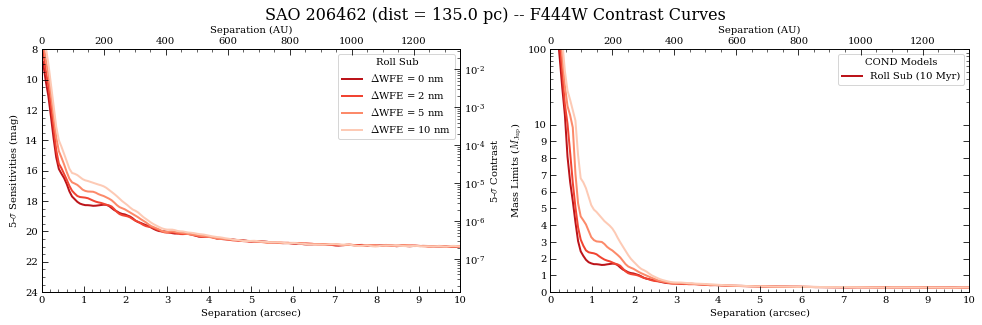

In [24]:
sat_rad = dmax[-1]
obs = obs_dict[filt_keys[-1]]
age = age_sci
do_plot_contrasts(None, curves_roll_F444W, nsig, wfe_list, obs, age, sat_rad=sat_rad,
                  yr=[24,8], save_fig=True, outdir=outdir)


## PDS 70

In [25]:
# Fit spectrum to SED photometry
i=4
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[1,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[2.62066110e-08 1.06733367e+07 3.54856009e+00]


In [26]:
# Do the same for the reference source
name_ref, spt_ref, kmag_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

mag_ref, bp_ref = kmag_ref, bp_k
args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
ref = nrc_utils.source_spectrum(*args)

ref.fit_SED(use_err=False, robust=False, wlim=[2,20])

# Final reference spectrum
sp_ref = ref.sp_model

Warning, 5 of 35 bins contained negative fluxes; they have been set to zero.
[1.04988513]


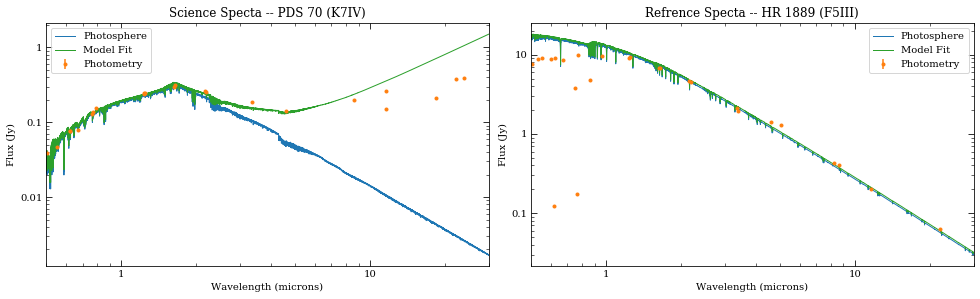

In [27]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

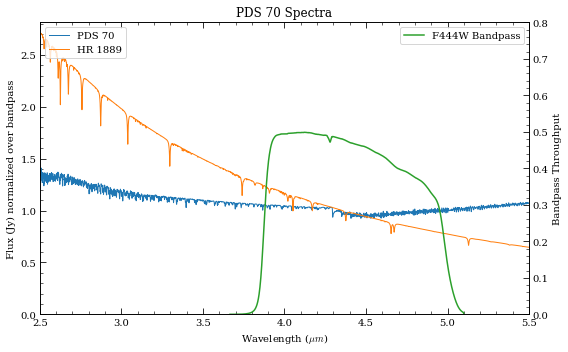

In [28]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    o = S.Observation(sp, bp, binset=bp.wave)
    sp.convert('Jy')
    f = sp.flux / o.effstim('Jy')

    ind = (w>=xr[0]) & (w<=xr[1])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized over bandpass')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [29]:
# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

In [30]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)


# # Generate initial observations for each filter(no WFE drift)
# def do_init(args_disk=None, fov_pix=None, verbose=True):
#     wfe_ref_drift = 0
#     obs_dict = obs_wfe(wfe_ref_drift, args_list, dist_sci, sp_ref=sp_ref, 
#                        args_disk=args_disk, fov_pix=fov_pix, verbose=verbose)
#     return obs_dict

# obs_dict = do_init(args_disk=args_disk, fov_pix=401, verbose=False)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [31]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,150,150)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

### Saturation 

In [32]:
# Max Saturation Values
dmax = []
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    dmax.append(dsat_asec)


F356W_MASK335R_CIRCLYOT
PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.07
  Sat Dist NG=2: 0.00 arcsec
HR 1889
  0 saturated pixel at NGROUP=2; Max Well: 0.12
  0 saturated pixel at NGROUP=10; Max Well: 0.67

F444W_MASK335R_CIRCLYOT
PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04
  Sat Dist NG=2: 0.00 arcsec
HR 1889
  0 saturated pixel at NGROUP=2; Max Well: 0.05
  0 saturated pixel at NGROUP=10; Max Well: 0.26


### Photon Limit Curves

In [33]:
nsig = 5
roll = 10

In [34]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


### Reference Reconstruction Curves

In [35]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_recon10 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

wfe_list = [5]
curves_recon5 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

wfe_list = [2]
curves_recon2 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


### Basic PSF Subtraction Curves

In [36]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_ref

wfe_list = [5]

curves_basic = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=True)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


### Roll Subtraction

In [37]:
for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon2 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [38]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_noref10 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

wfe_list = [5]
curves_noref5 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

wfe_list = [2]
curves_noref2 = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=roll)

F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


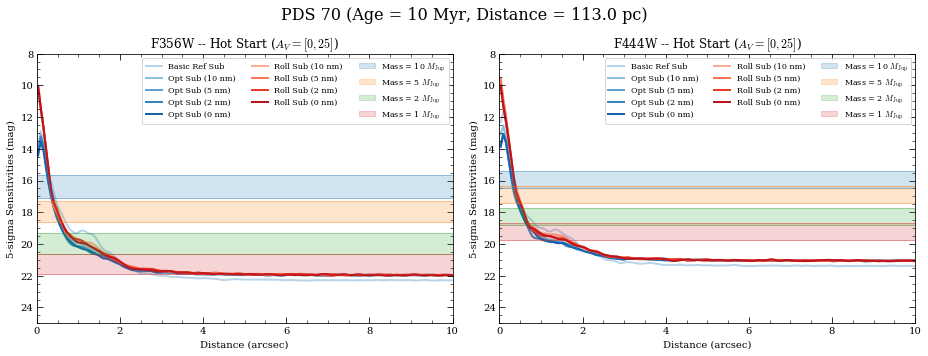

In [39]:
import matplotlib.patches as patches
from pynrc.obs_nircam import plot_planet_patches

fig, axes = plt.subplots(1,2, figsize=(13,5))
xlim1 = [0,5]
xlim2 = [0,10]
ylim  = [25,8]

curves_all = [curves_basic, curves_recon10, curves_recon5, curves_recon2, curves_photon]
labels = ['Basic Ref Sub', 'Opt Sub (10 nm)', 'Opt Sub (5 nm)', 
          'Opt Sub (2 nm)', 'Opt Sub (0 nm)']

lin_vals = np.linspace(0.2,0.7,len(curves_all))
cb = plt.cm.Blues_r(lin_vals)[::-1]

curves_all2 = [curves_noref10, curves_noref5, curves_noref2, curves_photon2]
labels2 = ['Roll Sub (10 nm)', 'Roll Sub (5 nm)', 
           'Roll Sub (2 nm)', 'Roll Sub (0 nm)']
lin_vals2 = np.linspace(0.2,0.7,len(curves_all2))
cr = plt.cm.Reds_r(lin_vals2)[::-1]

axes = axes.flatten()

for j, k in enumerate(filt_keys):
    for jj, cv in enumerate(curves_all):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cb[jj], zorder=1, lw=2, label=labels[jj])
    for jj, cv in enumerate(curves_all2):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cr[jj], zorder=1, lw=2, label=labels2[jj])
    
for j, ax in enumerate(axes):    
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))

    ax.set_xlim(xlim2)
    ax.set_ylim(ylim)
    
    obs = obs_dict[filt_keys[j]]
    plot_planet_patches(ax, obs, age=age_sci, update_title=True)
    
    ax.legend(ncol=3, loc=1, fontsize=8)
    
# Saturation levels
for j, ax in enumerate(axes):
    dy = ylim[1] - ylim[0]
    
    rect = patches.Rectangle((0, ylim[0]), dmax[j], dy, alpha=0.2,
                             color='k', zorder=2)
    ax.add_patch(rect)

fig.tight_layout()

dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''

fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
fig.subplots_adjust(top=0.85)
#fig.subplots_adjust(top=0.9)

fname = "{}_contrast2_{}.pdf".format(name_sci.replace(" ", ""), obs.mask)
fig.savefig(outdir+fname)

In [40]:
key_F444W = filt_keys[-1]
curves_roll_F444W = [curves_photon2[key_F444W][0], curves_noref2[key_F444W][0], 
                     curves_noref5[key_F444W][0], curves_noref10[key_F444W][0]]
wfe_list = [0,2,5,10]

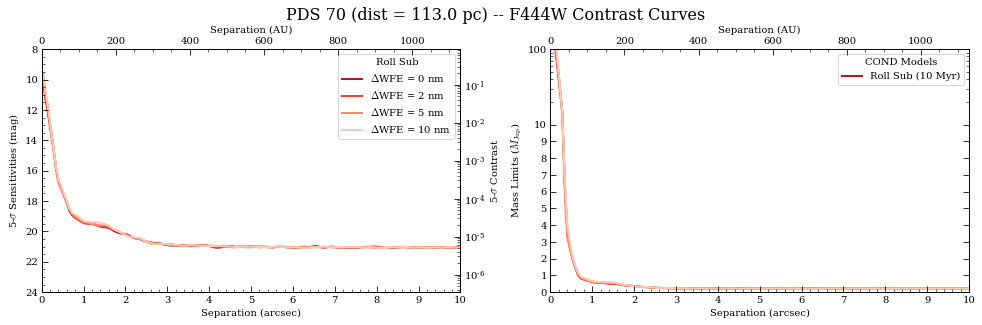

In [41]:
sat_rad = dmax[-1]
obs = obs_dict[filt_keys[-1]]
age = age_sci
do_plot_contrasts(None, curves_roll_F444W, nsig, wfe_list, obs, age, sat_rad=sat_rad,
                  yr=[24,8], save_fig=True, outdir=outdir)
